<a href="https://colab.research.google.com/github/Naila-elh/NLP_NYT_comments/blob/master/Projet_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning for NLP Project : What makes a good editorialist?**

By Naïla El Haouari & Félix Pasquier

*April, 12th 2020*

# Introduction

Nowadays, being a journalist is not an easy job. With the development of the internet and the arrival of social media, the profession has to re-invent itself. Journalists have to find new ways to convey quality information while appealing to the broadest audience they can. Most importantly, their work has to be attractive to the new generations. We are particularly interested in the work of the editorialists. In democracies such as the United States or France, they are very important for the public debate. They are the ones to present the right questions in relation to current national or global issues. 

As a consequence, our goal in this project consists in finding what makes a “good” editorialist. We will try to detect the “good” editorialists, that really contribute to the public debate, from the “bad” ones. 

To do this, we analyze the comments people left after reading the work of the New York Times editorialists. The New York Times plays a prominent role in shaping people's opinion and outlook on current affairs and also in setting the tone of the public discourse, especially in the USA. We will use the New York Times (NYT) comments database (https://www.kaggle.com/aashita/nyt-comments#CommentsApril2017.csv), which contains 9,000 articles from which we have information about their author and all the comments related to them. We will also use the Twitter US Airlines Sentiment Database (https://www.kaggle.com/crowdflower/twitter-airline-sentiment) as a way to train our models, since it has a similar classification as ours.


# 1. The Data 

In [0]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


The NYT data contains information about the comments made on the articles published in New York Times in Jan-May 2017 and Jan-April 2018. The month-wise data is given in two csv files - one each for the articles on which comments were made and for the comments themselves. The csv files for comments contain over 2 million comments in total with 34 features and those for articles contain 16 features about more than 9,000 articles.

We restrict our attention to editorialists. In other words, we only took the articles that were labelled as "OpEd" or "Editorial", with their corresponding comments. In addition, we focus on the editorialists who wrote at least 10 articles during this period.

Our goal consists in having some indicators about the editorialists' writing : how effective are their articles in providing food for thoughts? Are people happy/unhappy with their answers?  

It is very difficult to analyze each comment specifically. Indeed, a reader can express a positive sentiment over the editorialist's writing and/or opinions. However, they can express negative sentiment over the topic of the article. Here is an example :

"Sykes and his foolishness would be funny if it weren't so pathetic.
Do the republicans and their supporters who spew and  buy into this nonsense understand exactly how howlingly ridiculous they make themselves?
Mr. Kristof is right; they are on the wrong side of history. not only are women increasingly able to define themselves without benefit of their judgments, more and more men like mr. kristof are not only unthreatened by that, they support it.
Republicans, stop this foolishness and join the 21st century."

The person who wrote this comment clearly has a positive sentiment over the Mr. Kristof's work, yet expresses a negative sentiment about Mr. Sykes' speech, which was the topic of the article.

To deal with this issue, we decided to only focus on the sentences where the first name and/or last name of the editorialist were mentionned. We decided to remove all the articles written by "the editorial board", as we couldn't know precisely who wrote the articles. In addition, only a very tiny percentage of the comments referred directly to the "board". This left us with 78,962 comments. The code to create such database is in the appendix

In this project, we compute several indicators that we will use to assess the editorialists :
- the average number of comments an editorialist has by article;
- the average share of positive, negative comments each editorialist receives.  

## 1.1. Creation of a subset of the dataset

In [0]:
# Downloading the database
import pandas as pd
import glob, os    

articles = pd.concat(map(pd.read_csv, glob.glob(os.path.join('/content/gdrive/My Drive/Colab Notebooks/nyt_articles/', "*.csv"))))
comments = pd.concat(map(pd.read_csv, glob.glob(os.path.join('/content/gdrive/My Drive/Colab Notebooks/nyt_comments/', "*.csv"))))

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (32) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (32,33) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (14,15,31) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (25,26) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell

In [0]:
comments = comments.reset_index(drop=True)
articles = articles.reset_index(drop=True)

In [0]:
import re

In [0]:
# Keep articles OpEd and Editorial
articles = articles[articles['typeOfMaterial'].isin(['Op-Ed', 'Editorial'])]
len(articles)

1995

In [0]:
# Cleaning articles author name

# duplicate articles if several authors
authors = articles['byline'].str.split(',|and|with', expand=True).add_prefix('author_')

# remove everything before "by, BY, By" (interviewed by, etc.)
for col in authors.columns :
    authors.loc[~authors[col].isna(), col] = authors.loc[~authors[col].isna(), col].apply(lambda x: re.sub(r'.*(by|BY|By)', '', x).strip())

# merge to have article id
authors = pd.merge(authors, articles[['articleID']], left_index=True, right_index=True)

# stack df to have a df with one article-one author per row
authors = authors.set_index(['articleID']).stack().reset_index(level=-1, drop=True).reset_index(name='author')

# manually remove authors which are not real : "M.D" (which is a title), "Unknown"
authors = authors[~authors['author'].isin(['M.D', 'Unknown'])]

# keep authors who wrote 10 or more articles
authors_list = authors['author'].value_counts()[authors['author'].value_counts()>=10].index
authors = authors[authors['author'].isin(authors_list)]

len(authors['author'].unique())

22

In [0]:
# In the comments database, we keep only comments from the authors we kept, using the "articleID" variable.
comments = comments[comments['articleID'].isin(authors['articleID'].unique())]

# We also only keep comments that are not an answer to another comment
comments = comments.loc[comments['commentType']=='comment']

# Joining comments and authors
comments = comments.join(authors.set_index('articleID'), on='articleID')[['articleID','commentBody','commentID','author']]
comments = comments.drop_duplicates(subset=['commentID','author'], keep='first')

# We also remove the author "The Editorial Board" : we cannot consider them as an identified journalist
test_set = comments.loc[comments['author']!='THE EDITORIAL BOARD']
len(test_set)

388189

## 1.2. Tokenization of authors names

We want to tokenize the authors names to make it more easier to then select the sentences that contain the author's name

In [0]:
import nltk
nltk.download('punkt')

# lower the comments and authors names
test_set['commentBody'] = test_set['commentBody'].str.lower()
test_set['author'] = test_set['author'].str.lower()

# tokenize
test_set['author_tokens'] = test_set['author'].apply(nltk.word_tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [0]:
# Remove "m.", "l.", etc, that are "second names"
def clean_authors_names(author_token):
    issues = "".join([x for x in author_token if len(x)==2])
    if issues!="":
        author_token.remove(issues)
    else :
        pass
test_set['author_tokens'].apply(lambda x: clean_authors_names(x))

0          None
1          None
2          None
3          None
4          None
           ... 
2100204    None
2100205    None
2100206    None
2100207    None
2100208    None
Name: author_tokens, Length: 388189, dtype: object

In [0]:
# We select the comments that contain the author's name
test_set['ref_author'] = test_set.apply(lambda x: any(i in x.commentBody for i in x.author_tokens), axis=1)
test_set['ref_author'].value_counts()
test_set = test_set.loc[test_set['ref_author']==True].reset_index(drop=True).reset_index()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## 1.3. Extraction of the sentences that contain the journalist's name

We will only keep the sentences that contain the journalist's name. This way, the model will capture the sentiments towards the journalist, and not the general sentiment about the article topic.

In [0]:
def extract_sentence(i):
    row=test_set.loc[test_set.index==i]
    sentences=[]
    for author_name in row['author_tokens'][i] :
        if author_name in row['commentBody'][i]:
            sentences.extend(re.findall(r"(?:(?![.?]).|m\.|mr\.|ms\.|dr\.|prof\.)*"+ 
                                        re.escape(author_name) +
                                        r"(?:(?![.?]).|m\.|mr\.|ms\.|dr\.|prof\.)*[\"!?.]", row['commentBody'][i]))
    sentences = ' '.join(set(sentences))
    sentences = re.sub('<br/>', ' ', sentences)
    return sentences

In [0]:
test_set['sentences_author'] = test_set['index'].apply(lambda x: extract_sentence(x))

In [0]:
#from google.colab import files
#test_set.to_csv('test_set.csv', sep=";") 
#files.download('test_set.csv')

In [0]:
# # Export of 300 comments that we will manually label -- do it only once
# labels = test_set.sample(n=300)
# labels.to_csv('data/test_setlabel.csv', sep=";")
# labels['index'].to_csv('data/indexes_setlabel.csv', sep=';')

## 1.4. Descriptive statistics

We present some descriptive statistics about the data we are working on.

In [0]:
authors_statistics = test_set.groupby('author').agg('sum').reset_index()[['author','ref_author']]

# number of comments in editorials - total
nb_comments_total = comments.groupby('author').agg('count').reset_index()[['author','articleID']].rename(columns={'articleID':'nb_comments'})
nb_comments_total['author'] = nb_comments_total['author'].apply(lambda x: x.lower())

# Number of comments by author
authors_statistics = pd.merge(authors_statistics, nb_comments_total, on='author')
authors_statistics['ref_author_pct'] = authors_statistics['ref_author']/authors_statistics['nb_comments']*100

In [0]:
# Number of articles
def nb_articles(df):
  nb_comments_articles = df.groupby(['author','articleID']).agg('count').reset_index()[['author','articleID','commentID']].rename(columns={'commentID':'nb_comments'})
  nb_comments_articles['author'] = nb_comments_articles['author'].apply(lambda x: x.lower())
  nb_articles = nb_comments_articles.groupby('author').agg('count').reset_index()[['author','articleID']].rename(columns={'articleID':'nb_articles'})
  nb_comments_articles=nb_comments_articles.groupby('author').agg('mean').reset_index().rename(columns={"nb_comments":'nb_comments_by_article'})
  return nb_comments_articles, nb_articles

nb_comments_total, nb_articles_total = nb_articles(comments)
nb_comments_test, nb_articles_test = nb_articles(test_set)

In [0]:
# Database with the author's statistics
authors_statistics = pd.merge(authors_statistics, nb_articles_total, on="author").rename(columns={'nb_articles':'nb_articles_test'})
authors_statistics = pd.merge(authors_statistics, nb_articles_total, on="author").rename(columns={'nb_articles':'nb_articles_total'})
authors_statistics['articles_pct'] = authors_statistics['nb_articles_test']/authors_statistics['nb_articles_total']*100

authors_statistics = pd.merge(authors_statistics, nb_comments_test,on="author").rename(columns={'nb_comments_by_article':'nb_comments_by_article_test'})
authors_statistics = pd.merge(authors_statistics, nb_comments_total,on="author").rename(columns={'nb_comments_by_article':'nb_comments_by_article_total'})
authors_statistics['nb_comments_article_pct'] = authors_statistics['nb_comments_by_article_test']/authors_statistics['nb_comments_by_article_total']*100

authors_statistics

,author,ref_author,nb_comments,ref_author_pct,nb_articles_test,nb_articles_total,articles_pct,nb_comments_by_article_test,nb_comments_by_article_total,nb_comments_article_pct
0,andrew rosenthal,170.0,3094,5.494505,10,10,100.0,18.888889,309.400000,6.105006
1,bret stephens,3828.0,14651,26.127909,47,47,100.0,81.446809,311.723404,26.127909
2,charles m. blow,8470.0,39395,21.500190,61,61,100.0,138.852459,645.819672,21.500190
3,david brooks,17976.0,47493,37.849788,71,71,100.0,253.183099,668.915493,37.849788
4,david leonhardt,1394.0,18194,7.661867,46,46,100.0,30.304348,395.521739,7.661867
5,evan gershkovich,23.0,743,3.095559,20,20,100.0,1.769231,37.150000,4.762398
6,frank bruni,5857.0,36117,16.216740,72,72,100.0,81.347222,501.625000,16.216740
7,gail collins,3920.0,27493,14.258175,71,71,100.0,55.211268,387.225352,14.258175
8,jennifer finney boylan,194.0,2347,8.265871,14,14,100.0,13.857143,167.642857,8.265871
9,linda greenhouse,434.0,3042,14.266930,15,15,100.0,28.933333,202.800000,14.266930


In these graphs, we compare the number of articles, number of comments, and mean of number of comments per article, for each author. We represent two bars in the barplots: one for the comments as a whole, and one for the comments containing the journalist's name. We can therefore see if some authors are more cited than others. For the stacked barplots, both bars start at the y-axis, in order to better notice the proportions.

In [0]:
import matplotlib.pyplot as plt

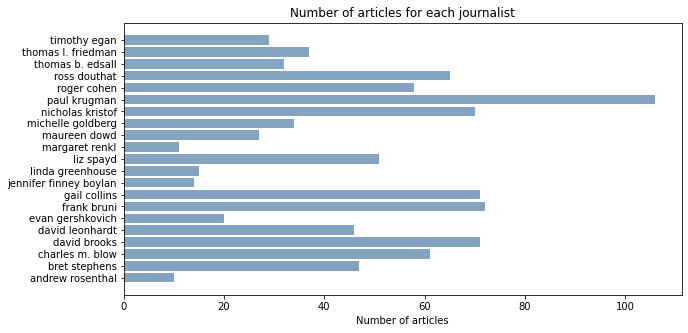

In [0]:
plt.figure(figsize=(10,5))
plt.barh(authors_statistics['author'], authors_statistics['nb_articles_total'], color=(0.2, 0.4, 0.6, 0.6))
plt.title("Number of articles for each journalist")
plt.xlabel('Number of articles')
plt.show()

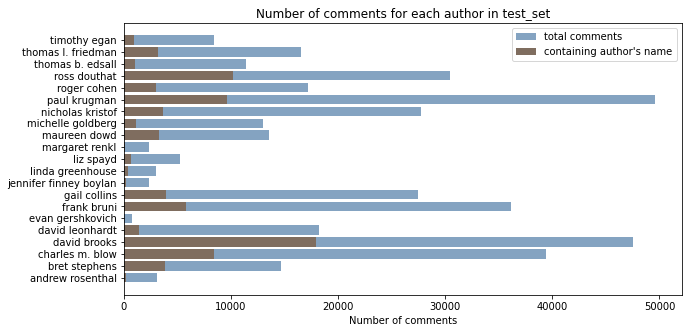

In [0]:
plt.figure(figsize=(10,5))
plt.barh(authors_statistics['author'], authors_statistics['nb_comments'], color=(0.2, 0.4, 0.6, 0.6), label='total comments')
plt.barh(authors_statistics['author'], authors_statistics['ref_author'], color='#7f6d5f', label="containing author's name")

plt.title("Number of comments for each author in test_set")
plt.xlabel('Number of comments')
plt.legend()
plt.show()

# in proportion of all comments, some journalists are more quoted than others

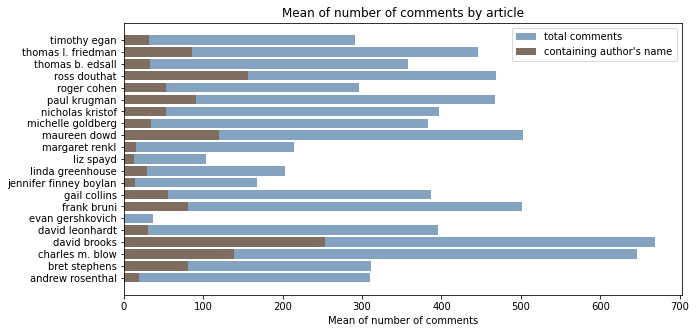

In [0]:
plt.figure(figsize=(10,5))
plt.barh(authors_statistics['author'], authors_statistics['nb_comments_by_article_total'], color=(0.2, 0.4, 0.6, 0.6), label='total comments')
plt.barh(authors_statistics['author'], authors_statistics['nb_comments_by_article_test'], color='#7f6d5f', label="containing author's name")

plt.title("Mean of number of comments by article")
plt.xlabel('Mean of number of comments')
plt.legend()
plt.show()

It seems that David Brooks and Charles Blow are really good at triggering some reactions and fostering some debate over the issues they raise.

# 2. Our Classification Model

To build our second indicator, we have to detect which comments are positive regarding the editorialist's work, which comments are negative and which comments are neural. To do so, we will build and deploy a sentiment analysis model based on BERT.

However, the NYT comments are not labelled so we cannot use them directly. 

To overcome this, we train our model using the Twitter US Airlines Sentiment database. We chose this dataset as the tweets are labelled either "negative", "positive" or "neutral". This is exactly how we want to classify our comments.

Then, we evaluate our model using 300 comments that we randomly selected from our previously constructed database and that we labelled ourselves.

## 2.1 Installing the GPU, downloading and importing libraries


In [0]:
# CHECK IF THE GPU IS INSTALLED

import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [0]:
# Other information about the GPU

import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [0]:
# We install the huggingface library which will give us a pytorch interface for working with BERT.

!pip install transformers

     |████████████████████████████████| 573kB 20.4MB/s 
     |████████████████████████████████| 870kB 46.8MB/s 
     |████████████████████████████████| 1.0MB 50.3MB/s 
     |████████████████████████████████| 3.7MB 48.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=fe99cb504414248d1ed551d773ef122ceacbee70b5f2c07f2078ee2db8b4e1ba
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [0]:
# We import all the libraries

import pandas as pd
import re
import random
import numpy as np

## 2.2 The Twitter US Airlines Sentiment Analysis Database

We use pandas to parse the "in-domain" training database and look at a few of its properties and data points.

In [0]:
! wget -O tweets.csv https://raw.githubusercontent.com/gguibon/gguibon.github.io/master/Tweets.csv

--2020-04-12 22:52:16--  https://raw.githubusercontent.com/gguibon/gguibon.github.io/master/Tweets.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [text/plain]
Saving to: ‘tweets.csv’

tweets.csv          100%[===================>]   3.26M  --.-KB/s    in 0.03s   

2020-04-12 22:52:17 (109 MB/s) - ‘tweets.csv’ saved [3421431/3421431]



In [0]:
dfTweets = pd.read_csv('tweets.csv')

In [0]:
# Some descriptive statistics
print('Number of tweets: {:,}\n'.format(dfTweets.shape[0]))

# Display 10 random rows from the data.
dfTweets.sample(10)

Number of tweets: 14,640



,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
11457,568104590387884032,negative,1.0000,Customer Service Issue,1.0000,US Airways,NaN,LayneHillesland,NaN,0,"@USAirways Spoke on the phone 3 or 4 times, bu...",NaN,2015-02-18 09:47:43 -0800,NaN,NaN
3008,568801535662166016,neutral,0.6596,NaN,0.0000,United,NaN,tjny753,NaN,0,@united Based on suggestions from other passen...,NaN,2015-02-20 07:57:08 -0800,"Elmira, NY",NaN
2297,569272738826694656,negative,1.0000,Can't Tell,0.6817,United,NaN,luko,NaN,0,@united you have a culture issue,NaN,2015-02-21 15:09:32 -0800,Pittsburgh,Quito
12894,569988479540695040,negative,1.0000,Customer Service Issue,0.6776,American,NaN,ekatz24,NaN,1,@AmericanAir should prob give me a refund sinc...,NaN,2015-02-23 14:33:38 -0800,NaN,Central Time (US & Canada)
2132,569346420139905024,negative,1.0000,Customer Service Issue,1.0000,United,NaN,ambersings,NaN,0,@united Airline SUCKS! Customer Service SUCKS!...,NaN,2015-02-21 20:02:19 -0800,New York,Pacific Time (US & Canada)
5532,568915536844759040,neutral,1.0000,NaN,NaN,Southwest,NaN,didieraur,NaN,0,@SouthwestAir tweet just popped up on my phone...,"[35.12084166, -89.84738331]",2015-02-20 15:30:08 -0800,"Memphis, Tennessee",Central Time (US & Canada)
3856,568077199162658816,neutral,1.0000,NaN,NaN,United,NaN,Bevil_Sarah,NaN,1,@united can you send a personal plane to get u...,NaN,2015-02-18 07:58:53 -0800,Mill Creek HS,NaN
7951,568937402837786625,positive,1.0000,NaN,NaN,Delta,NaN,misschris715,NaN,0,@JetBlue yes! Terra blue chips were my favorit...,NaN,2015-02-20 16:57:01 -0800,"los angeles, ca",Pacific Time (US & Canada)
632,570236138603950080,negative,0.6288,Bad Flight,0.6288,United,NaN,Evan_Flay,NaN,0,@united but it's hard to stay upset at someone...,"[29.98340611, -95.33682231]",2015-02-24 06:57:44 -0800,Seattle,Pacific Time (US & Canada)
3342,568511969335984128,negative,1.0000,Flight Attendant Complaints,0.6559,United,NaN,Tamarabrams,NaN,0,@united Rude grouchy agent at Dulles check-in ...,NaN,2015-02-19 12:46:30 -0800,Arlington Virginia,Eastern Time (US & Canada)


The two variables we actually care about are the tweets and their label.

In [0]:
# Reshaping the data so that 
dfTweets = dfTweets[['airline_sentiment','text']]
dfTweets.loc[:,'label'] = dfTweets.airline_sentiment.map({'negative':0,'neutral':2,'positive':1})
dfTweets = dfTweets.drop(['airline_sentiment'], axis=1)
dfTweets.head()

,text,label
0,@VirginAmerica What @dhepburn said.,2
1,@VirginAmerica plus you've added commercials t...,1
2,@VirginAmerica I didn't today... Must mean I n...,2
3,@VirginAmerica it's really aggressive to blast...,0
4,@VirginAmerica and it's a really big bad thing...,0


We pre-process tweets before using the BERT tokenizer

In [0]:
# We pre-process the data

def preprocess_tweet_1(tweet):
	#Preprocess the text in a single tweet
	#arguments: tweet = a single tweet in form of string 
	#convert the tweet to lower case
	tweet.lower()
	#remove all urls
	tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet)
	return tweet

def preprocess_tweet_2(tweet):
  #correct all multiple white spaces to a single white space
  tweet = re.sub('[\s]+', ' ', tweet)
  return tweet

def preprocess_tweet_3(tweet):
  #convert "#topic" to just "topic"
  tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
  return tweet

#def preprocess_tweet_4(tweet):
  #replace all @username by 'USER'
  #tweet = re.sub('@[^\s]+','USER', tweet)
  #return tweet

In [0]:
dfTweets['text'] = dfTweets['text'].apply(preprocess_tweet_1)
dfTweets['text'] = dfTweets['text'].apply(preprocess_tweet_2)
dfTweets['text'] = dfTweets['text'].apply(preprocess_tweet_3)
#dfTweets['text'] = dfTweets['text'].apply(preprocess_tweet_4)

In [0]:
# We are only interested in the sentences and their labels, in the form of lists
sentences = dfTweets.text.values
labels = dfTweets.label.values

## 2.3 Tokenization of the Tweets

We transform our dataset into the format that BERT can be trained on. The text must be split into tokens. Then, these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included with BERT. We use the "uncased" version.

In [0]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [0]:
# EXAMPLE 

# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  @VirginAmerica What @dhepburn said.
Tokenized:  ['@', 'virgin', '##ame', '##rica', 'what', '@', 'dh', '##ep', '##burn', 'said', '.']
Token IDs:  [1030, 6261, 14074, 14735, 2054, 1030, 28144, 13699, 8022, 2056, 1012]


In [0]:
# We perform one tokenization pass of the dataset in order to measure the maximum sentence length.

max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  60


However, we have very long sentences in our dataset of comments. We decide to be conservative and choose to put a `max_length` of 512 in the model. Although the training will be longer, we make sure to keep all the information in the sentences.

We will use the tokenizer.encode_plus function, that combines multiple steps in order to tokenize the text in a BERT-compatible way. encode_plus will:
- Tokenize the sentence.
- Prepend the [CLS] token to the start.
- Append the [SEP] token to the end.
- Map tokens to their IDs.
- Pad or truncate the sentence to `max_length`
- Create attention masks for [PAD] tokens.

In [0]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 256,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  @VirginAmerica What @dhepburn said.
Token IDs: tensor([  101,  1030,  6261, 14074, 14735,  2054,  1030, 28144, 13699,  8022,
         2056,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
      

Divide up our training set to use 90% for training and 10% for validation.

In [0]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

13,176 training samples
1,464 validation samples


We  create an iterator for our dataset using the torch DataLoader class

In [0]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

## 2.4 Training of the Model

We are using BertForSequenceClassification. 

In [0]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels-- 3 for us.
    output_attentions = False, 
    output_hidden_states = False, 
)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

We grab the training hyperparameters from within the stored model.

In [0]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

In [0]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 2, as it is enough
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

## 2.5 Training the Model 

In [0]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [0]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    50  of    412.    Elapsed: 0:01:09.
  Batch   100  of    412.    Elapsed: 0:02:20.
  Batch   150  of    412.    Elapsed: 0:03:31.
  Batch   200  of    412.    Elapsed: 0:04:42.
  Batch   250  of    412.    Elapsed: 0:05:52.
  Batch   300  of    412.    Elapsed: 0:07:03.
  Batch   350  of    412.    Elapsed: 0:08:13.
  Batch   400  of    412.    Elapsed: 0:09:24.

  Average training loss: 0.49
  Training epcoh took: 0:09:41

Running Validation...
  Accuracy: 0.84
  Validation Loss: 0.40
  Validation took: 0:00:23

======== Epoch 2 / 2 ========
Training...
  Batch    50  of    412.    Elapsed: 0:01:11.
  Batch   100  of    412.    Elapsed: 0:02:21.
  Batch   150  of    412.    Elapsed: 0:03:32.
  Batch   200  of    412.    Elapsed: 0:04:42.
  Batch   250  of    412.    Elapsed: 0:05:53.
  Batch   300  of    412.    Elapsed: 0:07:04.
  Batch   350  of    412.    Elapsed: 0:08:14.
  Batch   400  of    412.    Elapsed: 0:09:25.

  Averag

Let's view the summary of the training process.

In [0]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.49,0.4,0.84,0:09:41,0:00:23
2,0.31,0.4,0.84,0:09:42,0:00:23


## 2.6 Evaluation on our Labelled Comments

In [0]:
# We import our labelled comments
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/label.csv', error_bad_lines=False, sep=';', encoding = "ISO-8859-1")

In [0]:
df.sample(10)

,sentences_author,label
203,"face it mr blow, they fight dirty, they fight...",neutral
266,"the wall street journal leans conservative, ...",neutral
152,"<br/><br/>ross, your immodest proposals are a ...",negative
9,i've been a fan of mr. egan's writing for many...,negative
233,gail:<br/><br/>i wish i was amused by this opi...,neutral
226,thank you maureen dowd for putting the past we...,positive
196,"<br/><br/>moreover, methinks mr. douthat needs...",negative
109,i don't put david brooks in the main hall of a...,neutral
5,they aren't as stupid as dr. krugman and many...,negative
175,since that includes just about every republic...,positive


In [0]:
# Reshaping the data
df.rename(columns={'sentences_author':'text'},inplace=True)
df.loc[:,'labels'] = df.label.map({'negative':0,'neutral':2,'positive':1})
df = df.drop(['label'], axis=1)
df.head()

,text,labels
0,"frank, i'm typically in full alignment with yo...",2
1,i think professor krugman answered that ques...,1
2,""" <br/><br/>maureen has seen the greater truth...",1
3,"that said, i am with frank: a bit of real ""se...",1
4,another good article by edsall.,1


As previously, we pre-process the data

In [0]:
def preprocess_sentence(sen):
	#Preprocess the text in a single sentence
	#convert the sentence to lower case
	sen.lower()
	#remove all urls
	sen = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',sen)
	#correct all multiple white spaces to a single white space
	sen = re.sub('[\s]+', ' ', sen)
	#convert "#topic" to just "topic"
	sen = re.sub(r'#([^\s]+)', r'\1', sen)
	return sen

def remove_html(sen):
  sen = re.sub('<[^<]+?>', '', sen)
  return sen

def remove_hyphen(sen):
  sen = re.sub('\" ', '', sen)
  return sen

In [0]:
df['text'] = df['text'].apply(preprocess_sentence)
df['text'] = df['text'].apply(remove_html)
df['text'] = df['text'].apply(remove_hyphen)

In [0]:
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.text.values
labels = df.labels.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 300



We apply our tuned model to generate predictions on test set of comments.

In [0]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions, true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 300 test sentences...
    DONE.


In [0]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0, 1 or 2) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

In [0]:
pred = pd.DataFrame(flat_predictions,columns=['value'])
true = pd.DataFrame(flat_true_labels,columns=['value'])

In [0]:
pred.loc[:,'y_pred'] = pred.value.map({0:'negative',2:'neutral',1:'positive'})
true.loc[:,'y_true'] = true.value.map({0:'negative',2:'neutral',1:'positive'})
pred = pred.drop(['value'], axis=1)
true = true.drop(['value'], axis=1)

In [0]:
pred.loc[:,'y_pred_negative'] = pred.y_pred.map({'negative':1,'neutral':0,'positive':0})
pred.loc[:,'y_pred_positive'] = pred.y_pred.map({'negative':0,'neutral':0,'positive':1})
pred.loc[:,'y_pred_neutral'] = pred.y_pred.map({'negative':0,'neutral':1,'positive':0})

In [0]:
true.loc[:,'y_true_negative'] = true.y_true.map({'negative':1,'neutral':0,'positive':0})
true.loc[:,'y_true_positive'] = true.y_true.map({'negative':0,'neutral':0,'positive':1})
true.loc[:,'y_true_neutral'] = true.y_true.map({'negative':0,'neutral':1,'positive':0})

In [0]:
y_pred2 = pd.DataFrame({"y_pred_negative": pred["y_pred_negative"], "y_pred_positive": pred["y_pred_positive"], "y_pred_neutral": pred["y_pred_neutral"]}).to_numpy()
y_true2 = pd.DataFrame({"y_true_negative": true["y_true_negative"], "y_true_positive": true["y_true_positive"], "y_true_neutral": true["y_true_neutral"]}).to_numpy()

In [0]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sn

def show_eval(y_true, y_pred):
  print( classification_report(y_true, y_pred) )
  cm = confusion_matrix(y_true, y_pred) 
  labels = ['negative', 'neutral', 'positive']
  df_cm = pd.DataFrame(cm, index=labels, columns=labels)
  # config plot sizes
  sn.set(font_scale=1.2)
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 18}, cmap='coolwarm', linewidth=0.5, fmt="")
  plt.show()

              precision    recall  f1-score   support

    negative       0.40      0.93      0.56        90
     neutral       0.77      0.24      0.37       112
    positive       0.89      0.48      0.62        98

    accuracy                           0.53       300
   macro avg       0.68      0.55      0.52       300
weighted avg       0.70      0.53      0.51       300



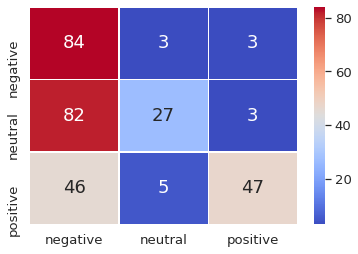

In [0]:
show_eval(np.array(true["y_true"]), np.array(pred["y_pred"]))

In [0]:
def ROC_plot(y_true, y_pred):  
  labels = ['negative', 'positive', 'neutral']
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i, label in enumerate(labels):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(label, roc_auc[i])

  for i, label in enumerate(labels):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for '+label)
    plt.legend(loc="lower right")
    plt.show()

negative 0.6619047619047619
positive 0.7249444332188321
neutral 0.5992591185410334


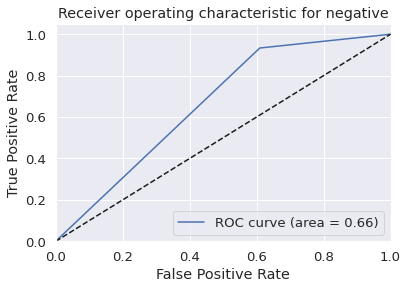

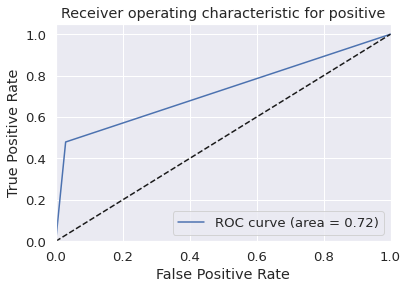

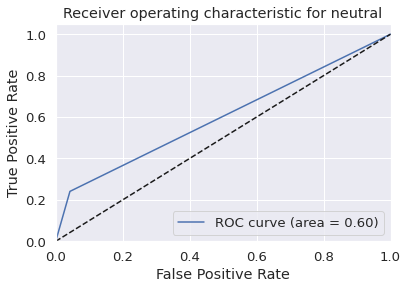

In [0]:
ROC_plot(y_true2,y_pred2)

Our model is not very good, in all criteria... We over-estimate negative comments. However, when we say that a comment is "positive", it is most of the time true.



In [0]:
df["predictions"] = flat_predictions
df.head()

,text,labels,predictions
0,"frank, i'm typically in full alignment with yo...",2,0
1,i think professor krugman answered that quest...,1,2
2,maureen has seen the greater truth behind the ...,1,0
3,"that said, i am with frank: a bit of real ""se...",1,0
4,another good article by edsall.,1,1


In [0]:
df_errors = df[df["labels"] != df["predictions"]]

Here are some comments that we miss-classified. As we can see, one of the main problems comes from the fact that negative or positive words are used to describe the topic of the article but not the work of the editorialist specifically...

In [0]:
list(df_errors.sample(5)["text"])

["i think i will follow david brook's lead in how i comment from now on.",
 'frank, wish i was there with you in italy, just walking the streets and wandering from pasta to espresso to ice cream, to. enjoy frank, and forget him for a few days.',
 ' since that includes just about every republican candidate and office holder, i agree with mr. blow, that sliver of the nation is beyond the pale. like mr. blow, i shut my ears to any politician who does not condemn racism, sexism and religious bigotry.',
 'brooks is right to suggest the possibility of a cancer lab as the right place for an historian to be.',
 "today, mr brooks, you read like the 'crazy vicar' version of your self."]

To reduce this problem, it would be better to train the model on labelled comments and not on tweets about US Airlines. It would probably require a lot of comments as topics are very varied in the editorials and it is really hard to disentangle the sentiments related to the article from the sentiments related to the editorialist.

In addition, a more complex model, with more layers, could be interesting

# 3. Prediction on the Whole Set of Sentences

## 3.1 Importing & Reshaping the data

Even though our prediction is really bad, we still compute our indicator, that is the average share of positive/negative/neutral comments per article for each editorialist

We import the whole set of sentences that contain the first and/or last name of an editorialist of the New York Times

In [0]:
whole_set = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/test_set.csv', error_bad_lines=False, sep=';', encoding = "ISO-8859-1")

In [0]:
whole_set.sample(10)

,Unnamed: 0,index,articleID,commentBody,commentID,author,author_tokens,ref_author,sentences_author
32494,32494,32494,5a8bfc4610f40f00018c1f01,"i couldnât agree with you more, mr. cohen...",2.60e+07,roger cohen,"['roger', 'cohen']",True,"i couldnât agree with you more, mr. cohen."
34007,34007,34007,5a8ff0cc10f40f00018c29b8,"""like a lot of parents i know, iâm dismayed ...",2.61e+07,michelle goldberg,"['michelle', 'goldberg']",True,"""<br/><br/>michelle, one of trump's legacies m..."
957,957,957,58e5ec707c459f24986d8ada,"mr. kristof are you attempting to ""normalize"" ...",2.21e+07,nicholas kristof,"['nicholas', 'kristof']",True,"mr. kristof are you attempting to ""normalize"" ..."
29034,29034,29034,5a7e4af4068401528a290799,one can assess the venal damage to government ...,2.59e+07,gail collins,"['gail', 'collins']",True,one can assess the venal damage to government ...
76605,76605,76605,5925346a7c459f24986e1562,...this sounds a little like friedman went to ...,2.26e+07,thomas l. friedman,"['thomas', 'friedman']",True,this sounds a little like friedman went to ame...
51198,51198,51198,5a540ae57c459f29e79b2e94,"david, i hear your argument, but i think the g...",2.55e+07,david brooks,"['david', 'brooks']",True,"david, i hear your argument, but i think the g..."
57139,57139,57139,58d225f97c459f247805d3fc,"mr. bruni,<br/>your offer to trump to actually...",2.19e+07,frank bruni,"['frank', 'bruni']",True,"mr. bruni,<br/>your offer to trump to actually..."
36164,36164,36164,586f538695d0e03926079490,"dr. krugman, to condemn a president-elect's po...",2.10e+07,paul krugman,"['paul', 'krugman']",True,"dr. krugman, to condemn a president-elect's po..."
61470,61470,61470,5a9aacc747de81a901209a2d,"if you run perpetual trade deficits, it means ...",2.62e+07,paul krugman,"['paul', 'krugman']",True,<br/><br/>i thought you could have nailed this...
20082,20082,20082,58a417fd95d0e024746368e2,thank you mr. bruni for helping americans rais...,2.15e+07,frank bruni,"['frank', 'bruni']",True,thank you mr. bruni for helping americans rais...


In [0]:
# Reshaping the data

whole_set.rename(columns={'sentences_author':'text'},inplace=True)
whole_set.head()

,Unnamed: 0,index,articleID,commentBody,commentID,author,author_tokens,ref_author,text
0,0,0,58def3237c459f24986d7c84,bravo gail !<br/>add to your list of the paria...,2.20e+07,gail collins,"['gail', 'collins']",True,bravo gail !<br/>add to your list of the paria...
1,1,1,58def3237c459f24986d7c84,"oh yeah gail we do ""wish this on"" everyone of ...",2.20e+07,gail collins,"['gail', 'collins']",True,"oh yeah gail we do ""wish this on"" everyone of ..."
2,2,2,58def3237c459f24986d7c84,gail collins' funny columns alone are worth th...,2.20e+07,gail collins,"['gail', 'collins']",True,gail collins' funny columns alone are worth th...
3,3,3,58def3237c459f24986d7c84,"as usual, very insightful ms. collins. to a p...",2.20e+07,gail collins,"['gail', 'collins']",True,"as usual, very insightful ms. collins."
4,4,4,58def3237c459f24986d7c84,once again gail collins demonstrates that she'...,2.20e+07,gail collins,"['gail', 'collins']",True,once again gail collins demonstrates that she'...


In [0]:
whole_set = whole_set[['author','articleID', 'text']]
whole_set.head()

,author,articleID,text
0,gail collins,58def3237c459f24986d7c84,bravo gail !<br/>add to your list of the paria...
1,gail collins,58def3237c459f24986d7c84,"oh yeah gail we do ""wish this on"" everyone of ..."
2,gail collins,58def3237c459f24986d7c84,gail collins' funny columns alone are worth th...
3,gail collins,58def3237c459f24986d7c84,"as usual, very insightful ms. collins."
4,gail collins,58def3237c459f24986d7c84,once again gail collins demonstrates that she'...


In [0]:
whole_set = whole_set.dropna()

In [0]:
whole_set['text'] = whole_set['text'].apply(preprocess_sentence)
whole_set['text'] = whole_set['text'].apply(remove_html)
whole_set['text'] = whole_set['text'].apply(remove_hyphen)

In [0]:
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(whole_set.shape[0]))

# Create sentence and label lists
sentences = whole_set.text.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 78,962



## 3.2 Prediction

In [0]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions = []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  
  # Store predictions and true labels
  predictions.append(logits)

print('    DONE.')

Predicting labels for 78,962 test sentences...
    DONE.


In [0]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
pred = pd.DataFrame(flat_predictions,columns=['value'])
pred.loc[:,'sentiment_predicted'] = pred.value.map({0:'negative',2:'neutral',1:'positive'})
pred = pred.drop(['value'], axis=1)

In [0]:
whole_set["sentiment_predicted"] = flat_predictions
whole_set.sample(10)

,author,articleID,text,sentiment_predicted
68065,paul krugman,5ab97a4e47de81a901217947,"his clear summary of their game, strategy, an...",0
33073,david brooks,5a949f1610f40f00018c32cc,"david, youâve contributed to the decline of ...",0
10187,david brooks,5acfe47e068401528a2a86bb,"as i read this contribution by mr. brooks, i k...",0
33108,david brooks,5a949f1610f40f00018c32cc,"epa, cfpb, pbs, public schools, state departme...",0
78232,david brooks,592d1d7d7c459f24986e2554,sorry david.,2
49197,charles m. blow,5a5c069c7c459f29e79b3f4f,"we are still, in 2018, too far from admitting...",0
51524,david brooks,5a540ae57c459f29e79b2e94,"""well informed enough to get by""""some think he...",0
16198,david brooks,58943d8995d0e0392607e662,trump-bannonism is believed because the republ...,0
73882,thomas l. friedman,591b8e417c459f24986dff73,"what we need now, author friedman, before it'...",0
34389,frank bruni,5a8ff0cc10f40f00018c29b7,"frank,as someone who has worked in the disabil...",1


In [0]:
#from google.colab import files
#whole_set.to_csv('final_set.csv') 
#files.download('final_set.csv')

# 4. Results

To conclude, we analyze the results we obtained with our model. We want to analyse the journalists that have more positive / negative comments.

In [0]:
#final = pd.read_csv('data/final_set.csv', sep=",")
final = whole_set

In [0]:
# Reshape the dataset and keep only important variables
final['sentiment_str'] = final['sentiment_predicted'].map({0:'negative',2:'neutral',1:'positive'})

final = final.groupby(['author','sentiment_str']).agg('count').reset_index()\
            .pivot(index='author',columns='sentiment_str', values='text').reset_index()
final['nb_comments'] = final.sum(axis=1)

# Percentage of negative/positive/neutral comments
for sentiment in ['positive','negative','neutral']:
    final[sentiment+'_pct'] = final[sentiment]/final['nb_comments']

final

sentiment_str,author,negative,neutral,positive,nb_comments,positive_pct,negative_pct,neutral_pct
0,andrew rosenthal,127.0,17.0,25.0,169.0,0.15,0.75,0.10
1,bret stephens,2664.0,624.0,526.0,3814.0,0.14,0.70,0.16
2,charles m. blow,5604.0,718.0,2111.0,8433.0,0.25,0.66,0.09
3,david brooks,13274.0,2470.0,2177.0,17921.0,0.12,0.74,0.14
4,david leonhardt,961.0,189.0,237.0,1387.0,0.17,0.69,0.14
5,evan gershkovich,20.0,3.0,NaN,23.0,NaN,0.87,0.13
6,frank bruni,3628.0,680.0,1527.0,5835.0,0.26,0.62,0.12
7,gail collins,2193.0,641.0,1065.0,3899.0,0.27,0.56,0.16
8,jennifer finney boylan,90.0,28.0,74.0,192.0,0.39,0.47,0.15
9,linda greenhouse,296.0,39.0,98.0,433.0,0.23,0.68,0.09


In graphs, we represent the numbers of positive/negative/neutral comments, for each journalist. Contrary to the graphs in the introduction, these graphs are stacked -- so the different bars in the barplots do not start at the y-axis.

In [0]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

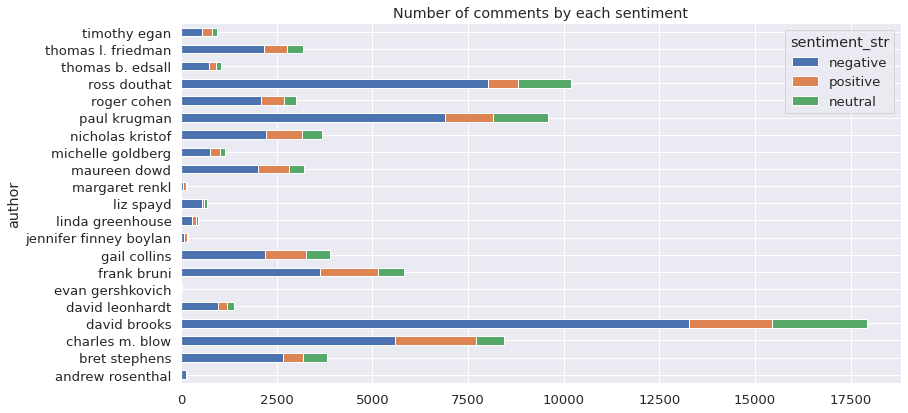

In [0]:
final.set_index('author')[['negative','positive','neutral']]\
                .plot.barh(stacked=True, title="Number of comments by each sentiment")
set_size(10,5)

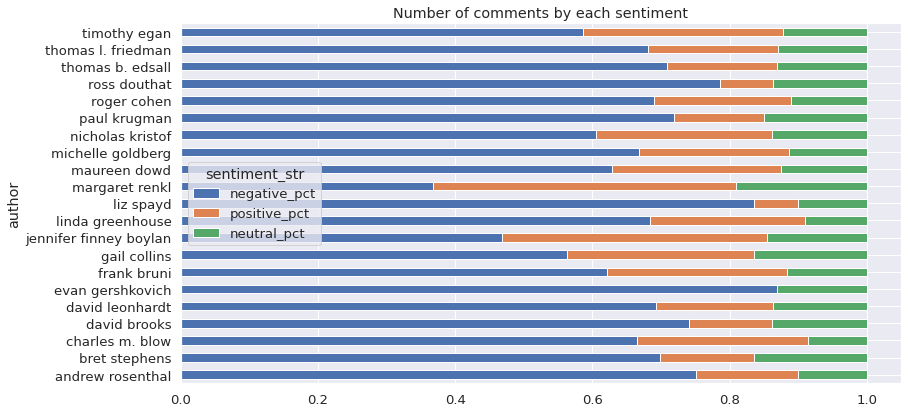

In [0]:
final.set_index('author')[['negative_pct','positive_pct','neutral_pct']]\
                .plot.barh(stacked=True, title="Number of comments by each sentiment")
set_size(10,5)

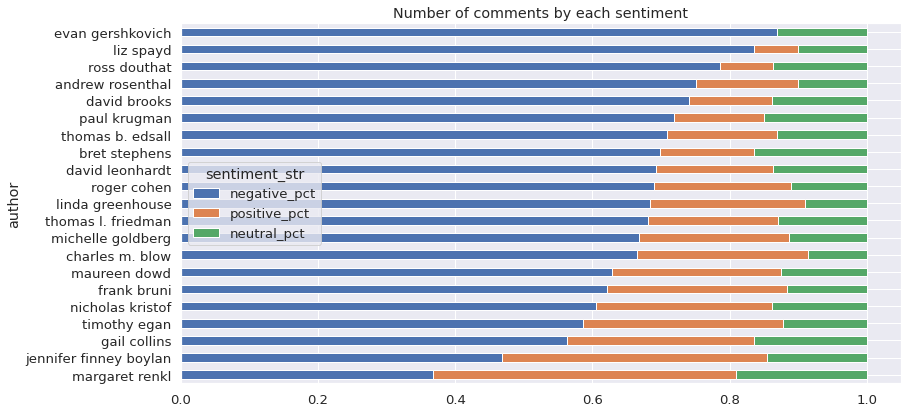

In [0]:
final.sort_values('negative_pct').set_index('author')[['negative_pct','positive_pct','neutral_pct']]\
                .plot.barh(stacked=True, title="Number of comments by each sentiment")
set_size(10,5)

The graphs of the predicted sentiments confirm that our model does not precisely work on our dataset. Indeed, the model does not predict well the negative sentiment -- too many comments are labellized as "negative". However, if we stand with this analysis, we can identify the journalists that have more positive comments (which is often correlated with having a few negative comments), and might be more popular among the audience.

# Conclusion

From our first indicator (the average number of comments per article), David Brooks and Charles Blow really seem able to stir some debate over the issues they raise. It is more difficult to assess the journalists based on our second indicator as our predictions are not particularly good. All we know is that the positive comments we predict are most of the true positive comments. From this perspective, we can infer that Margaret Renkl, Jennifer Finney Boylan and Gail Collins' writings appeal to a lot of NYT readers. 

On average, Nicholas Kristof seems to do pretty good on the two indicators.

A further interesting question for future work would be to understand what topics or which style triggers more reaction, more polarization or more consensus